# Dataset

In [1]:
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=202f804b-1e46-44a2-a981-9c91d106befe
To: /content/celeba_hq_256.zip
100% 297M/297M [00:06<00:00, 49.3MB/s]


In [ ]:
!unzip celeba_hq_256.zip

In [3]:
import os

file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [4]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [5]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [6]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [7]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask*torch.randn_like(img)
        mask_img = img*(1. - mask) + mask
        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [8]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [9]:
sample = next(iter(train_dataset))

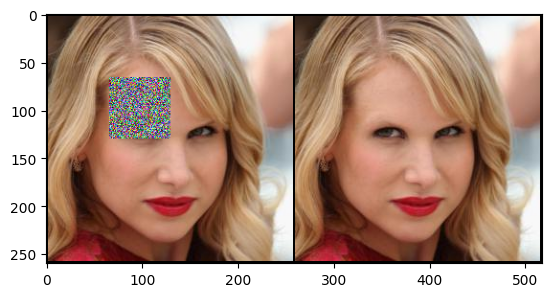

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [11]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [12]:
len(train_loader)

1

# Training

In [13]:
! pip install -q torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [14]:
from torchcfm.models.unet import UNetModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 1

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

0it [00:00, ?it/s]

In [ ]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

In [ ]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1, )
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image*(1. - mask) + mask*y
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

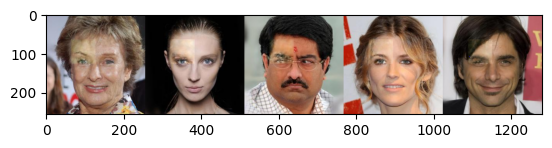

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
torch.save(model.state_dict(), "model_best.pth")